In [1]:
import numpy as np

N_SAMPLES = int(10**5)
RANDOM_SEED = 42

rng = np.random.RandomState(RANDOM_SEED)

In [2]:
from sklearn.datasets import make_classification

def generate_data(num_samples, prevalence=0.5, sensitive_prevalence=0.1, random_seed=42):
    
    # Generate features and labels with scikit-learn
    X, Y = make_classification(num_samples, weights=(1-prevalence, prevalence), random_state=random_seed)
    
    # Sensitive attrs
    rng = np.random.RandomState(random_seed)
    S = (rng.random(num_samples) + sensitive_prevalence).astype(int)

    return X, Y, S

In [3]:
X, Y, S = generate_data(num_samples=N_SAMPLES, random_seed=rng.randint(10**10))

In [4]:
# Split train, test
test_size = 0.2

indices = rng.permutation(N_SAMPLES)
test_indices = indices[: int(test_size * N_SAMPLES)]
train_indices = indices[int(test_size * N_SAMPLES): ]

X_train, y_train, s_train = X[train_indices], Y[train_indices], S[train_indices]
X_test, y_test, s_test = X[test_indices], Y[test_indices], S[test_indices]

# Use hpt package to train models

In [5]:
from pathlib import Path
HYPERPARAM_SPACE_PATH = Path() / 'hyperparameter_spaces'
HYPERPARAM_SPACE_PATH = HYPERPARAM_SPACE_PATH / 'sklearn.multiple_algorithms.yaml'

In [6]:
from hpt.tuner import ObjectiveFunction, OptunaTuner

obj_func = ObjectiveFunction(
    X_train, y_train, X_test, y_test,
    hyperparameter_space=HYPERPARAM_SPACE_PATH,
    eval_metric='accuracy',
    s_train=s_train,
    s_val=s_test,
    threshold=0.50,
)

tuner = OptunaTuner(obj_func) # NOTE: can pass other useful study kwargs here (e.g. storage)

[I 2022-11-29 11:22:03,060] A new study created in memory with name: no-name-3005ee9b-6249-43b6-be1b-f0744d718db2


In [7]:
%%time
tuner.optimize(n_trials=50, show_progress_bar=True, n_jobs=4)

/Users/acruz/opt/miniconda3/envs/py3.9-stable/lib/python3.9/site-packages/optuna/progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2022-11-29 11:22:03,818] Trial 0 finished with value: 0.90905 and parameters: {'learner_type': 'LR', 'learner_LR_penalty': 'l2', 'learner_LR_C': 1, 'learner_LR_tol': 0.004737377225318428, 'learner_LR_max_iter': 2292, 'learner_LR_solver': 'liblinear'}. Best is trial 0 with value: 0.90905.
[I 2022-11-29 11:22:04,175] Trial 4 finished with value: 0.90385 and parameters: {'learner_type': 'LR', 'learner_LR_penalty': 'l2', 'learner_LR_C': 0.001, 'learner_LR_tol': 0.004395717362981793, 'learner_LR_max_iter': 705, 'learner_LR_solver': 'liblinear'}. Best is trial 4 with value: 0.90385.
[I 2022-11-29 11:22:04,176] Trial 2 finished with value: 0.89985 and parameters: {'learner_type': 'DT', 'learner_DT_max_depth': 17, 'learner_DT_criterion': 'gini', 'learner_DT_min_samples_split': 59, 'learner_DT_min_samples_leaf': 25, 'learner_DT_splitter': 'best'}. Best is trial 2 with value: 0.89985.
[I 2022-11-29 11:22:05,621] Trial 5 finished with value: 0.90635 and parameters: {'learner_type': 'DT', 'lear

[I 2022-11-29 11:23:13,153] Trial 29 finished with value: 0.88965 and parameters: {'learner_type': 'DT', 'learner_DT_max_depth': 123, 'learner_DT_criterion': 'entropy', 'learner_DT_min_samples_split': 38, 'learner_DT_min_samples_leaf': 6, 'learner_DT_splitter': 'best'}. Best is trial 9 with value: 0.8714.
[I 2022-11-29 11:23:13,318] Trial 30 finished with value: 0.90905 and parameters: {'learner_type': 'LR', 'learner_LR_penalty': 'l2', 'learner_LR_C': 1, 'learner_LR_tol': 0.001651601348979485, 'learner_LR_max_iter': 3908, 'learner_LR_solver': 'liblinear'}. Best is trial 9 with value: 0.8714.
[I 2022-11-29 11:23:13,655] Trial 31 finished with value: 0.89355 and parameters: {'learner_type': 'DT', 'learner_DT_max_depth': 73, 'learner_DT_criterion': 'entropy', 'learner_DT_min_samples_split': 12, 'learner_DT_min_samples_leaf': 15, 'learner_DT_splitter': 'best'}. Best is trial 9 with value: 0.8714.
[I 2022-11-29 11:23:14,068] Trial 32 finished with value: 0.90155 and parameters: {'learner_ty

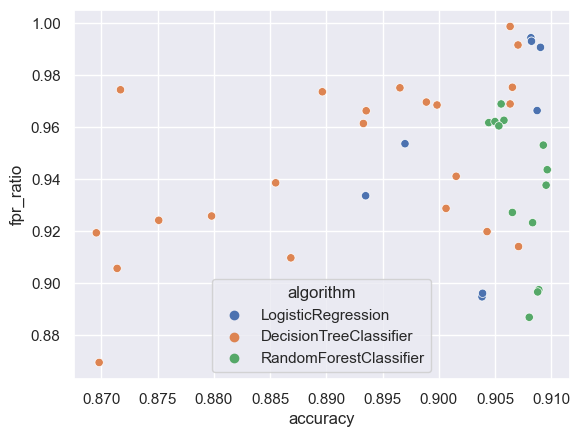

In [8]:
tuner.objective_function.plot(y_axis="fpr_ratio", pyplot_show=False, hue="algorithm")